In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import pandas as pd
import random
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
import numpy as np
from sklearn.utils.multiclass import unique_labels
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from tensorflow.keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.models import Model
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
x = np.load('/content/drive/MyDrive/Datasets/fold3/images.npy')
y = np.load('/content/drive/MyDrive/Datasets/fold3/types.npy')


In [ ]:
#encoding y
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

y = onehot_encoded

[3 3 3 ... 5 5 5]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 0)


In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(2177, 256, 256, 3) (2177, 19)
(545, 256, 256, 3) (545, 19)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state= 0)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1959, 256, 256, 3) (1959, 19)
(218, 256, 256, 3) (218, 19)
(545, 256, 256, 3) (545, 19)


**REsNet50**

In [ ]:
#@title resNet50
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
train_generator.fit(x_train)
val_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
val_generator.fit(x_val)
test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
test_generator.fit(x_test)
#Initializing ResNet50
from tensorflow.keras.applications import ResNet50
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
#Adding layers to the ResNet50
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'), input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(19,activation=('softmax')))
#model_resnet.summary()
from tensorflow.keras.optimizers import SGD
model_resnet.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#Training the ResNet50 model
rest_net_history = model_resnet.fit(x_train ,y_train, epochs=40, validation_data =(x_val, y_val), verbose=1)
test_score = model_resnet.evaluate(x_test, y_test, verbose = 1) 


94781440/94765736 [==============================] - 4s 0us/step
Epoch 1/40
62/62 [==============================] - 213s 3s/step - loss: 2.3078 - accuracy: 0.3931 - val_loss: 3.5517 - val_accuracy: 0.1606
Epoch 2/40
62/62 [==============================] - 203s 3s/step - loss: 1.6959 - accuracy: 0.5059 - val_loss: 2.9581 - val_accuracy: 0.2110
Epoch 3/40
62/62 [==============================] - 205s 3s/step - loss: 1.4196 - accuracy: 0.5743 - val_loss: 2.7747 - val_accuracy: 0.2798
Epoch 4/40
62/62 [==============================] - 203s 3s/step - loss: 1.2642 - accuracy: 0.6269 - val_loss: 1.8902 - val_accuracy: 0.5275
Epoch 5/40
62/62 [==============================] - 205s 3s/step - loss: 0.9900 - accuracy: 0.7039 - val_loss: 2.1365 - val_accuracy: 0.5229
Epoch 6/40
62/62 [==============================] - 208s 3s/step - loss: 0.8520 - accuracy: 0.7483 - val_loss: 3.3097 - val_accuracy: 0.3532
Epoch 7/40
62/62 [==============================] - 210s 3s/step - loss: 0.6466 - accurac

In [ ]:
model_resnet.save('resnet50 fold2.h5')

**Vgg19 model**

In [ ]:
#@title Default title text

from keras.applications.vgg19 import VGG19

# define cnn model
def define_model():
	# load model
	model = VGG19(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	# model.summary()
	return model

# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, rotation_range=2, zoom_range=.2)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train, y_train, batch_size = 128, epochs = 50, verbose = 1, validation_data = (x_val, y_val))

	# evaluate model
	acc = model.evaluate(x_test, y_test, verbose=1)
	
	model.save('vgg19 fold1.h5')


run_test_harness()

80150528/80134624 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
16/16 [==============================] - 113s 7s/step - loss: 8.2210 - accuracy: 0.1914 - val_loss: 2.8650 - val_accuracy: 0.2202
Epoch 2/50
16/16 [==============================] - 109s 7s/step - loss: 2.2562 - accuracy: 0.3129 - val_loss: 2.3914 - val_accuracy: 0.3303
Epoch 3/50
16/16 [==============================] - 109s 7s/step - loss: 1.8281 - accuracy: 0.4564 - val_loss: 2.3988 - val_accuracy: 0.3761
Epoch 4/50
16/16 [==============================] - 110s 7s/step - loss: 1.5663 - accuracy: 0.5089 - val_loss: 2.3792 - val_accuracy: 0.3945
Epoch 5/50
16/16 [==============================] - 109s 7s/step - loss: 1.3810 - accuracy: 0.5605 - val_loss: 2.3713 - val_accuracy: 0.3853
Epoch 6/50
16/16 [==============================] - 108s 7s/step - loss: 1.2283 - accuracy: 0.6023 - val_loss: 2.4115 - val_accuracy: 0.4174
Epoch 7/50
16/16 [==============================] - 109s 7s/step - loss: 1.1011 - accuracy: 0.6355 - val_loss: 2.4150 - val_accuracy: 0.4266
Epoch 8/50
16

**Vgg16**

In [ ]:
#@title Default title text
# from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	#model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True,zoom_range=.1)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train, y_train, epochs=50, verbose=1, validation_data = (x_val, y_val))
	# evaluate model
	acc = model.evaluate(x_test, y_test, verbose=1)
	
	# save model
	model.save('vgg16 fold1.h5')


run_test_harness()

58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
62/62 [==============================] - 92s 1s/step - loss: 4.4594 - accuracy: 0.2629 - val_loss: 2.2105 - val_accuracy: 0.3853
Epoch 2/50
62/62 [==============================] - 91s 1s/step - loss: 1.8347 - accuracy: 0.4232 - val_loss: 2.1188 - val_accuracy: 0.4541
Epoch 3/50
62/62 [==============================] - 91s 1s/step - loss: 1.5712 - accuracy: 0.4895 - val_loss: 2.1267 - val_accuracy: 0.4587
Epoch 4/50
62/62 [==============================] - 90s 1s/step - loss: 1.3877 - accuracy: 0.5426 - val_loss: 2.0446 - val_accuracy: 0.5046
Epoch 5/50
62/62 [==============================] - 90s 1s/step - loss: 1.2539 - accuracy: 0.5896 - val_loss: 2.1438 - val_accuracy: 0.5046
Epoch 6/50
62/62 [==============================] - 90s 1s/step - loss: 1.1182 - accuracy: 0.6217 - val_loss: 2.1500 - val_accuracy: 0.4817
Epoch 7/50
62/62 [==============================] - 89s 1s/step - loss: 0.9929 - accuracy: 0.6631 - val_loss: 2.2688 - val_accuracy: 0.4954
Epoch 8/50
62/62 [==

**DenseNet**

In [ ]:
#@title Default title text
import tensorflow as tf
base_model_denseNet= tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=y_train.shape[1],
    
)
#Adding layers to the ResNet50
model_dense=Sequential()
#Add the Dense layers along with activation and batch normalization
model_dense.add(base_model_denseNet)
model_dense.add(Flatten())
#Add the Dense layers along with activation and batch normalization
# model_dense.add(Dense(1024,activation=('relu'), input_dim=512))
model_dense.add(Dense(512,activation=('relu'))) 
model_dense.add(Dropout(.4))
model_dense.add(Dense(256,activation=('relu'))) 
model_dense.add(Dropout(.3))
model_dense.add(Dense(128,activation=('relu')))
model_dense.add(Dropout(.2))
model_dense.add(Dense(19,activation=('softmax')))

from tensorflow.keras.optimizers import SGD
model_dense.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
dense_net_history = model_dense.fit(x_train, y_train, epochs=50, validation_data = (x_val, y_val), verbose=1)
score = model_dense.evaluate(x_test, y_test, verbose= 1)

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/50
62/62 [==============================] - 412s 6s/step - loss: 2.5099 - accuracy: 0.3384 - val_loss: 3.5388 - val_accuracy: 0.1560
Epoch 2/50
62/62 [==============================] - 389s 6s/step - loss: 1.7183 - accuracy: 0.4793 - val_loss: 3.3866 - val_accuracy: 0.2018
Epoch 3/50
62/62 [==============================] - 408s 7s/step - loss: 1.5811 - accuracy: 0.5227 - val_loss: 2.6368 - val_accuracy: 0.2706
Epoch 4/50
62/62 [==============================] - 433s 7s/step - loss: 1.4519 - accuracy: 0.5590 - val_loss: 2.4621 - val_accuracy: 0.3394
Epoch 5/50
62/62 [==============================] - 430s 7s/step - loss: 1.3217 - accuracy: 0.6049 - val_loss: 2.1073 - val_accuracy: 0.4450
Epoch 6/50
62/62 [==============================] - 421s 7s/step - loss: 1.2195 - accuracy: 0.6309 - val_loss: 3.4260 - val_accuracy: 0.2615
Epoch 7/50
62/62 [==============================] - 394s 6s/step - loss: 1.1334 - accurac

In [ ]:
#First Spliting the dataset into three parts
x_train1, x_train3, y_train1, y_train3 = train_test_split(x,y, test_size=.33, random_state=0)
x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train1, y_train1, test_size=.50, random_state=0)

In [ ]:
#Now printing the shape and size of three parts
print(x_train1.shape, y_train1.shape)
print(x_train2.shape, y_train2.shape)
print(x_train3.shape, y_train3.shape)

(911, 256, 256, 3) (911, 19)
(912, 256, 256, 3) (912, 19)
(899, 256, 256, 3) (899, 19)


In [ ]:
# spliting x_train1 and y_train1 into train , validation and test set
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train1, y_train1, test_size=.2, random_state=1)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=.1, random_state=1)

#printing the shape
print("................printing the sahpe..............")
print(x_train1.shape, y_train1.shape)
print(x_val1.shape, y_val1.shape)
print(x_test1.shape, y_test1.shape)

................printing the sahpe..............
(655, 256, 256, 3) (655, 19)
(73, 256, 256, 3) (73, 19)
(183, 256, 256, 3) (183, 19)


In [ ]:
# spliting x_train2 and y_train2 into train , validation and test set
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=.1, random_state=1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train2, y_train2, test_size=.2, random_state=1)
#printing the shape
print("printing the sahpe..............")
print(x_train2.shape, y_train2.shape)
print(x_val2.shape, y_val2.shape)
print(x_test2.shape, y_test2.shape)

printing the sahpe..............
(656, 256, 256, 3) (656, 19)
(92, 256, 256, 3) (92, 19)
(164, 256, 256, 3) (164, 19)


In [ ]:
# spliting x_train3 and y_train3 into train , validation and test set
x_train3, x_val3, y_train3, y_val3 = train_test_split(x_train3, y_train3, test_size=.1, random_state=1)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x_train3, y_train3, test_size=.2, random_state=1)
#printing the shape
print("printing the sahpe..............")
print(x_train3.shape, y_train3.shape)
print(x_val3.shape, y_val3.shape)
print(x_test3.shape, y_test3.shape)

printing the sahpe..............
(647, 256, 256, 3) (647, 19)
(90, 256, 256, 3) (90, 19)
(162, 256, 256, 3) (162, 19)


**ResNet50 Model for ensembling**

In [ ]:
#@title Default title text
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
base_model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
train_generator.fit(x_train1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )
val_generator.fit(x_val1)
test_generator = ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1)
test_generator.fit(x_test1)


#Adding layers to the ResNet50
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())
#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'), input_dim=512))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(19,activation=('softmax')))

#Summary of ResNet50 Model
#model_resnet.summary()

model_resnet.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#Training the ResNet50 model
rest_net_history = model_resnet.fit(x_train1 ,y_train1, epochs=50, validation_data =(x_val1, y_val1), verbose=1)
score = model_resnet.evaluate(x_test1, y_test1, verbose=1)
model_resnet.save('resNet50-fold3.h5')

Epoch 1/50
21/21 [==============================] - 69s 3s/step - loss: 2.8989 - accuracy: 0.3023 - val_loss: 2.3106 - val_accuracy: 0.3699
Epoch 2/50
21/21 [==============================] - 62s 3s/step - loss: 1.9585 - accuracy: 0.4382 - val_loss: 38.0150 - val_accuracy: 0.2192
Epoch 3/50
21/21 [==============================] - 62s 3s/step - loss: 1.6141 - accuracy: 0.5389 - val_loss: 7.5608 - val_accuracy: 0.1781
Epoch 4/50
21/21 [==============================] - 62s 3s/step - loss: 1.3311 - accuracy: 0.6290 - val_loss: 2.7921 - val_accuracy: 0.1918
Epoch 5/50
21/21 [==============================] - 62s 3s/step - loss: 1.1876 - accuracy: 0.6260 - val_loss: 3.9886 - val_accuracy: 0.1918
Epoch 6/50
21/21 [==============================] - 62s 3s/step - loss: 0.8667 - accuracy: 0.7191 - val_loss: 2.8884 - val_accuracy: 0.2466
Epoch 7/50
21/21 [==============================] - 61s 3s/step - loss: 0.7476 - accuracy: 0.7771 - val_loss: 2.8125 - val_accuracy: 0.2877
Epoch 8/50
21/21 [=

**VGG19 for ensembling**

In [ ]:
#@title Default title text


from keras.applications.vgg19 import VGG19

# define cnn model
def define_model():
	# load model
	model = VGG19(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	# model.summary()
	return model

# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, rotation_range=2, zoom_range=.2)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train2, y_train2, batch_size = 128, epochs = 45, verbose = 1, validation_data = (x_val2, y_val2))

	# evaluate model
	acc = model.evaluate(x_test2, y_test2, verbose=1)
	
	model.save('vgg19-fold3.h5')


run_test_harness()

80150528/80134624 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/45
6/6 [==============================] - 37s 6s/step - loss: 10.9692 - accuracy: 0.1540 - val_loss: 7.4563 - val_accuracy: 0.2174
Epoch 2/45
6/6 [==============================] - 35s 6s/step - loss: 4.7902 - accuracy: 0.3491 - val_loss: 4.7385 - val_accuracy: 0.2174
Epoch 3/45
6/6 [==============================] - 34s 6s/step - loss: 2.0019 - accuracy: 0.5229 - val_loss: 3.6839 - val_accuracy: 0.2609
Epoch 4/45
6/6 [==============================] - 34s 6s/step - loss: 1.3333 - accuracy: 0.6189 - val_loss: 3.3493 - val_accuracy: 0.2935
Epoch 5/45
6/6 [==============================] - 34s 6s/step - loss: 0.9678 - accuracy: 0.7165 - val_loss: 3.1290 - val_accuracy: 0.3043
Epoch 6/45
6/6 [==============================] - 35s 6s/step - loss: 0.6706 - accuracy: 0.7957 - val_loss: 3.2813 - val_accuracy: 0.3913
Epoch 7/45
6/6 [==============================] - 34s 6s/step - loss: 0.4777 - accuracy: 0.8521 - val_loss: 3.4946 - val_accuracy: 0.4022
Epoch 8/45
6/6 [=================

**Model VGG16 using for ensemble**

In [ ]:
#@title Default title text


from keras.applications.vgg16 import VGG16

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(256, 256, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False

	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(19, activation='softmax')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.0001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	#model.summary()
	return model


# run the test harness for evaluating a model
def run_test_harness():
	
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True,zoom_range=.1)
	
	datagen.mean = [123.68, 116.779, 103.939]
	# fit model
	history = model.fit(x_train3, y_train3, epochs=45, verbose=1, validation_data = (x_val3, y_val3))
	# evaluate model
	acc = model.evaluate(x_test3, y_test3, verbose=1)
	
	# save model
	model.save('vgg16-fold3.h5')


run_test_harness()

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/45


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


21/21 [==============================] - 29s 1s/step - loss: 9.0383 - accuracy: 0.2287 - val_loss: 3.0373 - val_accuracy: 0.2778
Epoch 2/45
21/21 [==============================] - 28s 1s/step - loss: 1.7718 - accuracy: 0.4560 - val_loss: 2.8574 - val_accuracy: 0.3778
Epoch 3/45
21/21 [==============================] - 28s 1s/step - loss: 1.2911 - accuracy: 0.5842 - val_loss: 2.8630 - val_accuracy: 0.3444
Epoch 4/45
21/21 [==============================] - 28s 1s/step - loss: 0.9658 - accuracy: 0.6816 - val_loss: 2.9921 - val_accuracy: 0.4222
Epoch 5/45
21/21 [==============================] - 29s 1s/step - loss: 0.7286 - accuracy: 0.7620 - val_loss: 3.0827 - val_accuracy: 0.3778
Epoch 6/45
21/21 [==============================] - 28s 1s/step - loss: 0.5599 - accuracy: 0.8130 - val_loss: 3.0826 - val_accuracy: 0.4111
Epoch 7/45
21/21 [==============================] - 29s 1s/step - loss: 0.4443 - accuracy: 0.8624 - val_loss: 3.5575 - val_accuracy: 0.3889
Epoch 8/45
21/21 [=============

In [ ]:
#@title Sequential model 1
# #Model 1

# #Defining the Convolutional Neural Network
# model1 = Sequential()

# model1.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Conv2D(64, (3, 3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Conv2D(128, (3, 3), activation='relu'))
# model1.add(MaxPooling2D(pool_size = (2, 2)))
# model1.add(Dropout(0.2))

# model1.add(Flatten())

# model1.add(Dense(128, activation = 'relu'))
# model1.add(Dense(19, activation = 'softmax'))


# #If your targets are one-hot encoded, use categorical_crossentropy. Examples of one-hot encodings:
# # If your targets are integers, use sparse_categorical_crossentropy. 

# #model1.compile(loss ='sparse_categorical_crossentropy', optimizer='adam', metrics =['acc'])
# model1.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model1.summary()

# #Training the CNN model1
# #history = model1.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test))
# history1 = model1.fit(x_train1, y_train1, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model1.save('model 1 fold1 epoch 10.hdf5')

In [ ]:
#@title sequential model 2
# model2 = Sequential()

# model2.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model2.add(Conv2D(32, (3, 3), activation='relu'))
# model2.add(MaxPooling2D(pool_size = (2, 2)))

# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(Conv2D(64, (3, 3), activation='relu'))
# model2.add(MaxPooling2D(pool_size = (2, 2)))

# model2.add(Conv2D(128, (3, 3), activation='relu'))
# model2.add(Conv2D(25, (1,1)))

# model2.add(Flatten())

# model2.add(Dense(19, activation = 'softmax'))

# model2.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model2.summary()

# history2 = model2.fit(x_train1, y_train1, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model2.save('model2 fold1 epoch 10.hdf5')

In [ ]:
#@title Sequential model 3

# model3 = Sequential()

# model3.add(Conv2D(32, (3, 3), input_shape = (256,256,3), activation='relu'))
# model3.add(MaxPooling2D(pool_size = (2, 2)))
# model3.add(Dropout(0.2))

# model3.add(Conv2D(64, (3, 3), activation='relu'))
# model3.add(MaxPooling2D(pool_size = (2, 2)))
# model3.add(Dropout(0.2))

# model3.add(Flatten())

# model3.add(Dense(19, activation = 'softmax'))

# #If your targets are one-hot encoded, use categorical_crossentropy. Examples of one-hot encodings:
# # If your targets are integers, use sparse_categorical_crossentropy. 

# #model1.compile(loss ='sparse_categorical_crossentropy', optimizer='adam', metrics =['acc'])
# model3.compile(loss ='categorical_crossentropy', optimizer='adam',metrics =['acc'])
# #model3.summary()

# #Training the CNN model1
# #history = model1.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, y_test))
# history3 = model3.fit(x_train2, y_train2, batch_size = 128, epochs = 10, verbose = 1, validation_data = (x_test, y_test))

# model3.save('model3 fold3 epoch 10.hdf5')


**Ensembling all the three models (VGG16, Vgg19, RestNet50)**


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

In [ ]:
model1 = load_model('resNet50-fold3.h5')
model2 = load_model('vgg19-fold3.h5')
model3 = load_model('vgg16-fold3.h5')


In [ ]:
models = [model1, model2, model3] 


In [ ]:
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_test)
prediction2 = model2.predict(x_test)
prediction3 = model3.predict(x_test)


In [ ]:
accuracy1 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction1, axis=1))
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction2, axis= 1))
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction3, axis= 1))


ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model1 =  0.6220183486238532
Accuracy Score for model2 =  0.43669724770642204
Accuracy Score for model3 =  0.8440366972477065
Accuracy Score for average ensemble =  0.8275229357798165


In [ ]:
#Weighted average ensemble
models = [model1, model2,model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.3, .1,.6] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)

In [ ]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6220183486238532
Accuracy Score for model2 =  0.43669724770642204
Accuracy Score for model3 =  0.8440366972477065
Accuracy Score for average ensemble =  0.8275229357798165
Accuracy Score for weighted average ensemble =  0.8513761467889909


In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w2=", max_acc_row[2], " and w3=", max_acc_row[3])         


Max accuracy of  0.1  obained with w1= 0.0  w2= 0.1  and w3= 86.42201834862385


In [ ]:
class_names =['Adrenal', 'Bile duct', 'Bladder', 'Breast', 'Colon', 'Cervix', 'Esophagus', 'Head&Neck', 'Kidney', 'Liver', 'Lung', 'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Testis', 'Stomach', 'Thyroid', 'Uterus']

Predicted Label:  Breast
True Label:  Breast


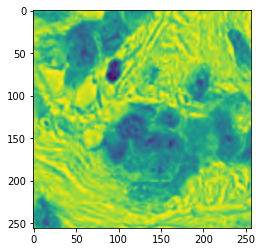

In [ ]:
# Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [.3, .1,.6] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test[i])])



**Ensembling resNet50 and vgg19**

In [ ]:
model1 = load_model('resNet50-fold3.h5')
model2 = load_model('vgg19-fold3.h5')
models = [model1, model2] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_test)
prediction2 = model2.predict(x_test)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction1, axis=1))
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction2, axis= 1))



ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)


print('Accuracy Score for average ensemble = ', ensemble_accuracy)
#Weighted average ensemble
models = [model1, model2] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.7,.3] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6220183486238532
Accuracy Score for model2 =  0.43669724770642204
Accuracy Score for average ensemble =  0.6
Accuracy Score for model1 =  0.6220183486238532
Accuracy Score for model2 =  0.43669724770642204
Accuracy Score for average ensemble =  0.6
Accuracy Score for weighted average ensemble =  0.6128440366972477


In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
            wts = [w1/10.,w2/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w2=", max_acc_row[2])         


Max accuracy of  0.4  obained with w1= 0.1  w2= 62.38532110091744


Predicted Label:  Breast
True Label:  Breast


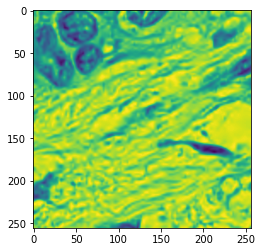

In [ ]:
# Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt
models = [model1, model2]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [.7,.3] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test[i])])



**Ensembling resnet50 and vgg16**

In [ ]:
model1 = load_model('resNet50-fold3.h5')
model3 = load_model('vgg16-fold3.h5')
models = [model1, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(x_test)
prediction3 = model3.predict(x_test)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction1, axis=1))
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction3, axis= 1))



ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy3)


print('Accuracy Score for average ensemble = ', ensemble_accuracy)
#Weighted average ensemble
models = [model1, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.7,.3] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6220183486238532
Accuracy Score for model3 =  0.8440366972477065
Accuracy Score for average ensemble =  0.8642201834862385
Accuracy Score for model1 =  0.6220183486238532
Accuracy Score for model3 =  0.8440366972477065
Accuracy Score for average ensemble =  0.8642201834862385
Accuracy Score for weighted average ensemble =  0.7431192660550459


In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
            wts = [w1/10.,w2/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w3=", max_acc_row[2])         


Max accuracy of  0.1  obained with w1= 0.1  w3= 86.42201834862385


In [ ]:
#Weighted average ensemble
models = [model1, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.2,.8] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.6220183486238532
Accuracy Score for model3 =  0.8440366972477065
Accuracy Score for average ensemble =  0.8642201834862385
Accuracy Score for weighted average ensemble =  0.8440366972477065


Predicted Label:  Cervix
True Label:  Breast


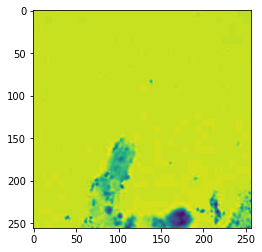

In [ ]:
# Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt
models = [model1, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [.4,.6] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test[i])])



**Ensembling vgg19 & vgg16**

In [ ]:
model2 = load_model('vgg19-fold3.h5')
model3 = load_model('vgg16-fold3.h5')
models = [model2, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

In [ ]:
ensemble_prediction = np.argmax(summed, axis=1)

prediction2 = model2.predict(x_test)
prediction3 = model3.predict(x_test)

accuracy2 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction2, axis=1))
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), np.argmax(prediction3, axis= 1))



ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model2 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy3)


print('Accuracy Score for average ensemble = ', ensemble_accuracy)
#Weighted average ensemble
models = [model2, model3] 
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)

weights = [.4,.6] 

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis= 1), weighted_ensemble_prediction)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model2 =  0.6220183486238532
Accuracy Score for model3 =  0.8440366972477065
Accuracy Score for average ensemble =  0.8458715596330275
Accuracy Score for model2 =  0.43669724770642204
Accuracy Score for model3 =  0.8440366972477065
Accuracy Score for average ensemble =  0.8458715596330275
Accuracy Score for weighted average ensemble =  0.8495412844036697


In [ ]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
            wts = [w1/10.,w2/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w2=", max_acc_row[1],
      " w3=", max_acc_row[2])         


Max accuracy of  0.2  obained with w2= 0.3  w3= 84.95412844036697


Predicted Label:  Breast
True Label:  Ovarian


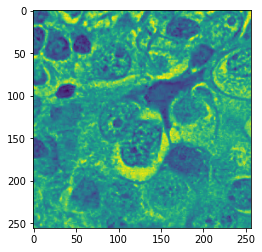

In [ ]:
# Explore metrics for the ideal weighted ensemble model. 
import matplotlib.pyplot as plt
models = [model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [.4,.6] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



i = random.randint(1,len(ideal_weighted_ensemble_prediction))
plt.imshow(x_test[i,:,:,0]) 
print("Predicted Label: ", class_names[int(ideal_weighted_ensemble_prediction[i])])
print("True Label: ", class_names[np.argmax(y_test[i])])

